# Nibo DataAnalysisChallenge: Rodrigo Madeira

The following code is intended to create two Cohort analysis: one that indicates the business creation rate over the months since the hiring date of the accountant and another that indicates the accountants contract termination rate over the months (accountant churn rate).

A qualitative analysis will also be developed for the relationship between the lack of accountant engagement rate (first cohort chart) and accountant churn rate (second cohort chart).

### 1. Importing Packages and Libraries

In [2]:
import pandas as pd
import os as os
import seaborn as sns
import getpass
import sqlite3
import requests
import json
from pandasql import sqldf
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

pysqldf = lambda q: sqldf(q, globals())

### 2. Defining Directory

In [2]:
user = getpass.getuser()
path = 'C:/Users/'+user+'/Documents/nibo'
try:
    os.mkdir(path)
except:
    pass
os.chdir(path)
os.getcwd()

'C:\\Users\\rodrigo.madeira\\Documents\\nibo'

### 3. Building Database

#### 3.1 createdOrganizations

Importing and reading the createdOrganizations.sql file from Github

In [3]:
r = requests.get('https://raw.githubusercontent.com/nibodev/'+
                 'DataAnalysisChallenge/master/SRC/CreatedOrganizations.sql')

Removing the Primary Key code line due to existing duplicates

In [4]:
sql_file = r.text.replace(' PRIMARY KEY', '')

Creating Local Database with sqlite

In [6]:
conn = sqlite3.connect('nibo.db')
cur = conn.cursor()
cur.executescript(sql_file)
conn.commit()

createdOrganizations = pd.read_sql_query("select * from createdOrganizations;",
                                         conn)
createdOrganizations.head()

,accountantId,accountantCreateDate,organizationId,organizationCreateDate
0,A2DDF47E,2019-04-18 13:24:06.363,BDEC6494,2019-04-18 17:53:17.790
1,A2DDF47E,2019-04-18 13:24:06.363,E488EC4B,2019-04-18 17:53:17.817
2,A2DDF47E,2019-04-18 13:24:06.363,9A344ACD,2019-04-18 17:53:17.940
3,A2DDF47E,2019-04-18 13:24:06.363,696AEADD,2019-04-18 17:53:17.963
4,A2DDF47E,2019-04-18 13:24:06.363,AB37A456,2019-04-18 17:53:18.123


Removing duplicates and saving the csv file for later use

In [7]:
dupl_check = pd.DataFrame(createdOrganizations.groupby('organizationId') \
                          ['organizationCreateDate'].count())
dupl_list = dupl_check \
            [dupl_check['organizationCreateDate']>1].index.values.tolist()
print('As seguintes empresas estão duplicadas na base: ' \
      +str(dupl_list).replace('[', '').replace(']', ''))
createdOrganizations.drop_duplicates(subset='organizationId', 
                                     keep='first', 
                                     inplace=True)
createdOrganizations.to_csv('createdOrganizations.csv', 
                            index=False)

As seguintes empresas estão duplicadas na base: '2EA9ABB3', '5C8F5C9C', 'B8C436C5', 'EDC9E4B9'


#### 3.2 accountantContracts

Importing and reading the accountantContracts.json file from Github and saving the csv file for later use

In [8]:
r = requests.get('https://raw.githubusercontent.com/nibodev/'+
                 'DataAnalysisChallenge/master/SRC/accountantContracts.json')
json_file = json.loads(r.text)
accountantContracts = json_normalize(json_file)
accountantContracts.to_csv('accountantContracts.csv', 
                           index=False)
accountantContracts.head()

,accountantId,cancelDate,ignoreField,signDate,signedOrganizationsCount
0,2239C5F5,21/05/2019,None,2018-12-11T00:00:00,50.0
1,22A7B6CA,None,None,2019-08-30T00:00:00,200.0
2,22BBCCCB,None,None,2019-08-21T00:00:00,20.0
3,22C2E247,None,None,2019-08-13T00:00:00,100.0
4,22EB8F2A,None,None,2019-04-18T00:00:00,135.0


### 4. Data Preprocessing

In [9]:
createdOrganizations = pd.read_csv('createdOrganizations.csv')
accountantContracts = pd.read_csv('accountantContracts.csv')

Completing the accountantContracts dataframe by merging both Dataframes

In [10]:
accountantContracts = \
pd.merge(accountantContracts, 
         createdOrganizations[['accountantId',
                               'accountantCreateDate']].drop_duplicates(), 
         how='left', 
         on='accountantId')
accountantContracts.drop(['ignoreField'], 
                         axis=1, 
                         inplace=True)
createdOrganizations.drop(['accountantCreateDate'], 
                          axis=1, 
                          inplace=True)
accountantContracts.head()

,accountantId,cancelDate,signDate,signedOrganizationsCount,accountantCreateDate
0,2239C5F5,21/05/2019,2018-12-11T00:00:00,50.0,NaN
1,22A7B6CA,NaN,2019-08-30T00:00:00,200.0,2019-08-26 14:13:42.200
2,22BBCCCB,NaN,2019-08-21T00:00:00,20.0,NaN
3,22C2E247,NaN,2019-08-13T00:00:00,100.0,2019-08-26 13:00:49.953
4,22EB8F2A,NaN,2019-04-18T00:00:00,135.0,2019-05-14 13:01:16.113


Fixing the Datetime columns

In [11]:
accountantContracts["signDate"] = \
accountantContracts["signDate"].str.split("T", 
                                           expand = True)[0]
accountantContracts['signDate'] = \
pd.to_datetime(accountantContracts['signDate'])
accountantContracts['accountantCreateDate'] =  \
pd.to_datetime(accountantContracts['accountantCreateDate'])
createdOrganizations['organizationCreateDate'] =  \
pd.to_datetime(createdOrganizations['organizationCreateDate'])

accountantContracts['signDate_month'] = \
accountantContracts['signDate'].dt.month
createdOrganizations['organizationCreateDate_month'] = \
createdOrganizations['organizationCreateDate'].dt.month

accountantContracts.head()
createdOrganizations.head()

,accountantId,organizationId,organizationCreateDate,organizationCreateDate_month
0,A2DDF47E,BDEC6494,2019-04-18 17:53:17.790,4
1,A2DDF47E,E488EC4B,2019-04-18 17:53:17.817,4
2,A2DDF47E,9A344ACD,2019-04-18 17:53:17.940,4
3,A2DDF47E,696AEADD,2019-04-18 17:53:17.963,4
4,A2DDF47E,AB37A456,2019-04-18 17:53:18.123,4


Creating the preliminary accountant commitment Dataframe

In [12]:
base_engaj_accountant = pysqldf("""
SELECT
A.accountantId,
A.signDate_month AS cohort,
A.signedOrganizationsCount AS total,
B.organizationCreateDate_month AS m,
B.count_org
FROM accountantContracts A
JOIN
(
SELECT
accountantId,
organizationCreateDate_month,
COUNT(DISTINCT organizationId) AS count_org
FROM createdOrganizations
GROUP BY
accountantId,
organizationCreateDate_month
) B ON A.accountantId = B.accountantId

""")

base_engaj_accountant.head()

,accountantId,cohort,total,m,count_org
0,22A7B6CA,8,200.0,8,1
1,22A7B6CA,8,200.0,9,248
2,22C2E247,8,100.0,8,83
3,22C2E247,8,100.0,9,46
4,22EB8F2A,4,135.0,5,131


Creating the preliminary organization creation rate Dataframe

In [13]:
cohort_org = pysqldf("""
SELECT
A.cohort,
COUNT(A.accountantId) AS count_accountant,
B.total,
A.m,
SUM(count_org) AS count_org
FROM base_engaj_accountant A
LEFT JOIN
(
SELECT
cohort,
SUM(total) AS total
FROM base_engaj_accountant
GROUP BY
cohort
) B ON A.cohort = B.cohort
GROUP BY
A.cohort,
A.m,
B.total
""")

cohort_org.head()

,cohort,count_accountant,total,m,count_org
0,1,3,1045.0,2,131
1,1,1,1045.0,3,1
2,1,1,1045.0,4,2
3,1,1,1045.0,6,53
4,1,3,1045.0,7,71


#### 4.1 Creating the First Cohort Analysis: Organization Creation Rate

Filtering Dataframe due to limitations on the createdOrganizations table (only has data from between February and September)

In [14]:
cohort_org = cohort_org[(cohort_org['cohort']>1) & (cohort_org['cohort']<12)]

Calculating the respective month for each metric

In [15]:
cohort_org = cohort_org[cohort_org['cohort']<=cohort_org['m']]
cohort_org['m'] = cohort_org['m']-cohort_org['cohort']
cohort_org = cohort_org.reset_index(drop=True)

Calculating the cumulative sum as a percentage from the total

In [16]:
cohort_org['count_org'] = cohort_org.groupby('cohort')['count_org'].cumsum()
cohort_org['count_org'] = cohort_org['count_org']/cohort_org['total']
cohort_org.drop(['count_accountant', 'total'], 
                axis=1, 
                inplace=True)

cohort_org.head()

,cohort,m,count_org
0,2,0,0.149333
1,2,1,0.170963
2,2,2,0.172296
3,2,3,0.175852
4,2,4,0.242370


Pivotting the Dataframe

In [17]:
cohort_org = round(cohort_org.pivot_table(index=['cohort'], 
                                          columns='m', 
                                          values='count_org'),2)

cohort_org.head()

m,0,1,2,3,4,5,6,7
cohort,,,,,,,,
2,0.15,0.17,0.17,0.18,0.24,0.25,0.26,0.27
3,0.03,0.11,0.12,0.13,0.24,0.26,0.26,NaN
4,0.05,0.22,0.24,0.25,0.26,0.27,NaN,NaN
5,0.14,0.31,0.34,0.35,0.36,NaN,NaN,NaN
6,0.22,0.34,0.38,0.39,NaN,NaN,NaN,NaN


#### 4.2 Creating the Second Cohort Analysis: Accountant Churn

In [37]:
cohort_acc = base_engaj_accountant.copy()

Completing the Dataframe with the cancelDate data

In [38]:
cohort_acc.drop(['total','m','count_org'], 
                axis=1, 
                inplace=True)
cohort_acc = pd.merge(cohort_acc, 
                      accountantContracts[['accountantId', 'cancelDate']], 
                      how='left', 
                      on='accountantId')

cohort_acc.head()

,accountantId,cohort,cancelDate
0,22A7B6CA,8,NaN
1,22A7B6CA,8,NaN
2,22C2E247,8,NaN
3,22C2E247,8,NaN
4,22EB8F2A,4,NaN


Fixing the Datetime columns

In [39]:
cohort_acc['cancelDate'] =  pd.to_datetime(cohort_acc['cancelDate'], 
                                           format="%d/%m/%Y")
cohort_acc['m'] = cohort_acc['cancelDate'].dt.month
cohort_acc.drop(['cancelDate'], 
                axis=1, 
                inplace=True)

cohort_acc.head()

,accountantId,cohort,m
0,22A7B6CA,8,NaN
1,22A7B6CA,8,NaN
2,22C2E247,8,NaN
3,22C2E247,8,NaN
4,22EB8F2A,4,NaN


Processing the Dataframe

In [40]:
cohort_acc['m'] = cohort_acc['m'].fillna(0)

cohort_acc = pysqldf("""
SELECT
A.cohort,
B.total,
A.m,
COUNT(DISTINCT CASE WHEN m>0 THEN A.accountantId ELSE NULL END) AS count_dp_acc
FROM cohort_acc A
LEFT JOIN
(
SELECT
cohort,
COUNT(DISTINCT accountantId) AS total
FROM cohort_acc
GROUP BY
cohort
) B ON A.cohort = B.cohort
GROUP BY
A.cohort,
A.m,
B.total
""")

cohort_acc.head()

,cohort,total,m,count_dp_acc
0,1,5,0.0,0
1,1,5,5.0,1
2,2,11,0.0,0
3,2,11,4.0,1
4,2,11,6.0,1


Filtering Dataframe in order to make both cohort analysis' charts comparable

In [41]:
cohort_acc = cohort_acc[(cohort_acc['cohort']>1) & (cohort_acc['cohort']<12)]

Calculating the respective month for each metric

In [42]:
cohort_list = ['2','3','4','5','6','7','8','9']
m_list = ['2','3','4','5','6','7','8','9']

for cohort in cohort_list:
    for m in m_list:
        m = int(m)
        cohort = int(cohort)
        df= []
        total = int(cohort_acc.loc[cohort_acc['cohort'] == cohort] \
                    ['total'].tolist()[0])
        df.append((cohort,total,m,0))
        df = pd.DataFrame(df)
        df.rename(columns = {0:'cohort',
                             1:'total',
                             2:'m',
                             3:'count_dp_acc'}, 
                  inplace = True)
        cohort_acc = cohort_acc.append(df)

cohort_acc = cohort_acc.sort_values(by=['cohort','m']).reset_index(drop=True)

cohort_acc = pysqldf("""
SELECT
cohort,
total,
m,
SUM(count_dp_acc) AS count_dp_acc
FROM cohort_acc
GROUP BY
cohort,
total,
m
""")

cohort_acc = cohort_acc[cohort_acc['cohort']<=cohort_acc['m']]
cohort_acc['m'] = cohort_acc['m']-cohort_acc['cohort']
cohort_acc = cohort_acc.reset_index(drop=True)

cohort_acc.head()

,cohort,total,m,count_dp_acc
0,2,11,0.0,0
1,2,11,1.0,0
2,2,11,2.0,1
3,2,11,3.0,0
4,2,11,4.0,1


Calculating the cumulative sum as a percentage from the total

In [43]:
cohort_acc['count_dp_acc'] = \
cohort_acc.groupby('cohort')['count_dp_acc'].cumsum()
cohort_acc['count_acc'] = cohort_acc['total']-cohort_acc['count_dp_acc']
cohort_acc['count_acc'] = cohort_acc['count_acc']/cohort_acc['total']
cohort_acc.drop(['count_dp_acc', 'total'], 
                axis=1, 
                inplace=True)

cohort_acc.head()

,cohort,m,count_acc
0,2,0.0,1.000000
1,2,1.0,1.000000
2,2,2.0,0.909091
3,2,3.0,0.909091
4,2,4.0,0.818182


Pivotting the Dataframe

In [44]:
cohort_acc = round(cohort_acc.pivot_table(index=['cohort'], 
                                          columns='m', 
                                          values='count_acc'),2)

cohort_acc

m,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
cohort,,,,,,,,
2,1.0,1.00,0.91,0.91,0.82,0.73,0.73,0.73
3,1.0,1.00,1.00,0.82,0.73,0.73,0.73,NaN
4,1.0,1.00,1.00,1.00,1.00,0.97,NaN,NaN
5,1.0,0.98,0.95,0.93,0.91,NaN,NaN,NaN
6,1.0,0.96,0.95,0.93,NaN,NaN,NaN,NaN
7,1.0,1.00,1.00,NaN,NaN,NaN,NaN,NaN
8,1.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5. Plotting the Cohorts

#### 5.1 First Cohort Analysis: Organization Creation Rate

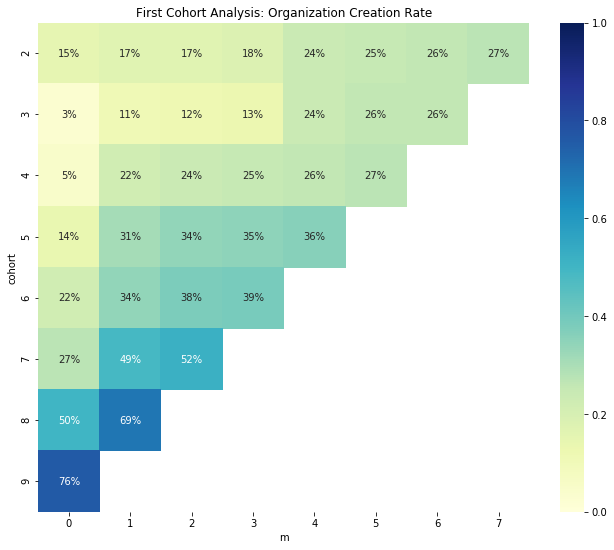

In [45]:
plt.figure(figsize = (11,9))
plt.title('First Cohort Analysis: Organization Creation Rate')
cohort_org_plot = sns.heatmap(data = cohort_org, 
                              annot = True, 
                              fmt = '.0%', 
                              vmin = 0.0,
                              vmax = 1.0,
                              cmap = "YlGnBu")

#### 5.2 Second Cohort Analysis: Accountant Churn

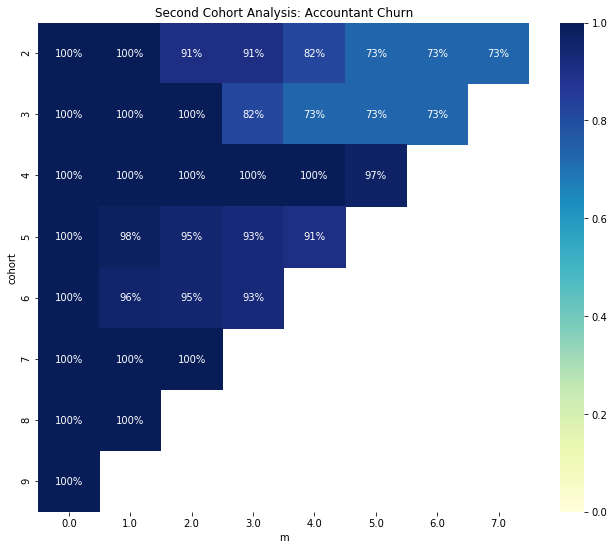

In [47]:
plt.figure(figsize = (11,9))
plt.title('Second Cohort Analysis: Accountant Churn')
cohort_acc_plot = sns.heatmap(data = cohort_acc, 
                              annot = True, 
                              fmt = '.0%', 
                              vmin = 0.0,
                              vmax = 1.0,
                              cmap = "YlGnBu")

### 6. Cohorts Correlation Hypothesis: Qualitative Analysis

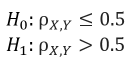
The main goal for the analysis is to try and reject the null hypothesis (H0), that there is no correlation between both metrics (lack of accountant engagement rate and accountant churn rate). For that, we will aim for a correlation coefficient of at least greater than 50%.

The cohorts to be analysed are: #2, #3, #5, #5 and #6. The cohorts #7, #8 and #9 presented a null variance for the accountant churn rate.

In [36]:
cohort_org = cohort_org.T
cohort_acc = cohort_acc.T
df_corr = pd.merge(pd.DataFrame(cohort_org.corrwith(cohort_acc)), 
              pd.DataFrame(base_engaj_accountant.groupby('cohort') \
                           ['accountantId'].nunique()), 
              how='left', 
              on='cohort').dropna()
df_corr = df_corr.rename(columns={0: 'corr', 'accountantId': 'acc_weight'})
df_corr

,corr,acc_weight
cohort,,
2,-0.963531,11
3,-0.901650,11
4,-0.326030,37
5,-0.832710,55
6,-0.971985,57


Cohort 2:


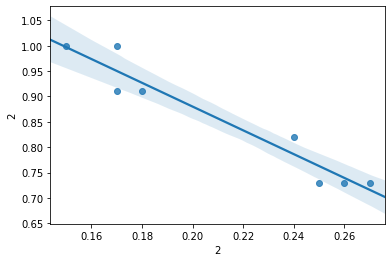

In [38]:
print('Cohort 2:')
sns.regplot(cohort_org[2], cohort_acc[2])

Cohort 3:


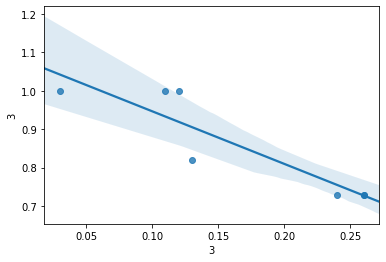

In [39]:
print('Cohort 3:')
sns.regplot(cohort_org[3], cohort_acc[3])

Cohort 4:


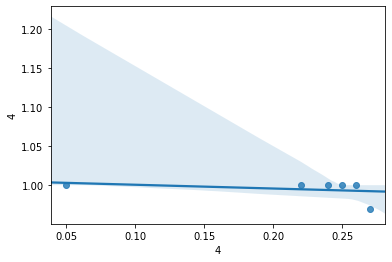

In [41]:
print('Cohort 4:')
sns.regplot(cohort_org[4], cohort_acc[4])

Cohort 5:


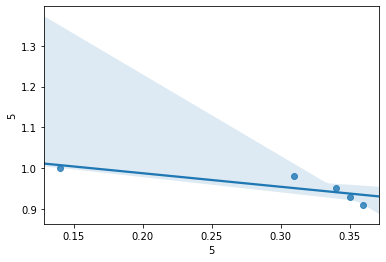

In [42]:
print('Cohort 5:')
sns.regplot(cohort_org[5], cohort_acc[5])

Cohort 6:


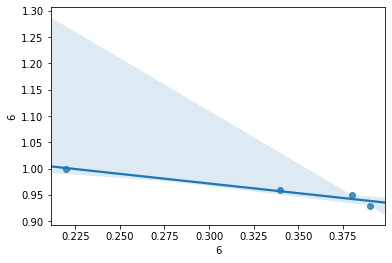

In [43]:
print('Cohort 6:')
sns.regplot(cohort_org[6], cohort_acc[6])

In [44]:
print('The weighted correlation between the lack of accountant engagement '+
      'rate and accountant churn rate is of '+
str(round((((df_corr['corr']*df_corr['acc_weight']).sum())/
     df_corr['acc_weight'].sum())*(-1), 4)*100)+'%.')

The weighted correlation between the lack of accountant engagement rate and accountant churn rate is of 78.24%.


A correlation greater than 80% is generally described as strong, while a correlation less than 50% is generally described as weak. The correlation for the following example is as high as 80%, so we can assume the correlation in this case is fairly strong and therefore we can statiscally reject the null hipothesis that there is no correlation between both metrics.

The worst correlation within the cohorts was for cohort #4, but that was expected with such a linear data for the accountant churn rates. By the other hand, the best correlation was for cohort #2, which despites its high correlation, didn't have a great impact on the final weighted correlation due to its low distinct count of accountants.

There was no churn for the cohorts #7, #8 and #9. We can assume that there was some sort of engagement action plan with a main goal of increasing Nibo's accountants retention at some point in July for the newest client base.